In [1]:
import csv
import numpy as np 
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt 
import pickle
import statistics
import numpy as np  
import sys

pd.set_option('display.max_rows', 4000)
pd.set_option('display.max_columns', 200)

In [2]:
from langdetect import detect
from langdetect import DetectorFactory
DetectorFactory.seed = 0

In [3]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

**Sentiment Analysis provided by Upasana - Tweets need to be cleaned prior to using.**


In [4]:
def sentiment_analyzer_score_for_englishOnlyTweet(cleaned_tweet): #this function takes in a tweet that has been detected as an english tweet
    score = analyser.polarity_scores(cleaned_tweet) #so this cleaned_tweet is always an english tweet.
    lb = score['compound']
    return lb

**Read in list of users to analyze**

In [5]:
# df = pd.read_csv('English_MentionedBackUsers_withCleanedData.csv')
df = pd.read_csv('Filtered_EnglishUsers_DidnotMentionBackUsers.csv')
UserList = list(df['Users'])

In [6]:
print(UserList[0])
len(UserList)

tamarindlemur


1435

In [7]:
iraContactPoints = pd.read_csv('contact_IRAtoUser.csv')
# iraContactPoints.head()

**Create dict of contact points, formatted: username -> [list of contact points]**

In [8]:
iraContactDict = {}
for i in range(len(iraContactPoints)):
    
    temp_list = iraContactPoints['tweet_date'][i].split(', ')
    temp_list[0] = temp_list[0][1:]
    temp_list[-1] = temp_list[-1][:-1]
    for j in range(len(temp_list)):
        temp_list[j] = temp_list[j][1:]
        temp_list[j] = temp_list[j][:-1]
#     temp_list.sort()
    iraContactDict[iraContactPoints['username'][i]] = temp_list


In [9]:
for key in iraContactDict:
    temp_list = iraContactDict[key]
    temp_list.sort()


In [10]:
# for key in iraContactDict:
#     print(key)
#     print(iraContactDict[key])
#     print("\n\n")

**Functions to check for a mention of Donald Trump or Hillary Clinton in a tweet**


In [11]:
def mentions_trump(mention_string):
    if mention_string != "[]": 
        mention_list = mention_string.split(', ')
        mention_list[0] = mention_list[0][1:]
        mention_list[-1] = mention_list[-1][:-1]
        for x in range(len(mention_list)):
            mention_list[x] = mention_list[x][1:]
            mention_list[x] = mention_list[x][:-1]
        for x in range(len(mention_list)):
            if mention_list[x] == 'realdonaldtrump':
                return True
    return False

In [12]:
def mentions_clinton(mention_string):
    if mention_string != "[]": 
        mention_list = mention_string.split(', ')
        mention_list[0] = mention_list[0][1:]
        mention_list[-1] = mention_list[-1][:-1]
        for x in range(len(mention_list)):
            mention_list[x] = mention_list[x][1:]
            mention_list[x] = mention_list[x][:-1]
        for x in range(len(mention_list)):
            if mention_list[x] == 'hillaryclinton':
                return True
    return False

**Create new DataFrame, which will hold all before / after analysis date in the form of lists**

In [13]:
beforeAfterDF = pd.DataFrame(columns=['username', 'first_contact', 'second_contact',
                                      'third_contact','tweet_count','sentiment_scores', 
                                      'trump_count', 'clinton_count'])

**Create dictionary of users first tweet dates**

Format: { [username] : str(date) }

In [14]:
first_tweet_dict = {}

**Iterate through users and perform before / after analysis**

In [15]:
size = str(len(UserList))
for i in range(len(UserList)):
# for i in range(10):
    try:
        #create temp DF
        temp_user_db = pd.read_csv('/home/updu6059/Twint_Data/ParallelProcessing/OnlyEnglishTweets/'+UserList[i]+'.csv', header=None, low_memory=False)
        #save first tweet date
        first_tweet_date = temp_user_db[3][len(temp_user_db)-1]
        first_tweet_dict[UserList[i]] = first_tweet_date
        #initialize values
        tweet_count = [
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        trump_count = [
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        clinton_count = [
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        sentiment_scores = [
            [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]

        username = UserList[i]
        contact_list = iraContactDict[username]
        first_contact = contact_list[0][:-6]
        first_contact = dt.strptime(first_contact, "%Y-%m-%d")
        second_contact = None
        third_contact = None
        if(len(contact_list) >= 2):
            second_contact = contact_list[1][:-6]
            second_contact = dt.strptime(second_contact, "%Y-%m-%d")
        if(len(contact_list) >= 3):
            third_contact = contact_list[2][:-6]
            third_contact = dt.strptime(third_contact, "%Y-%m-%d")
        #iterate through all tweets
        for j in range(len(temp_user_db)):
            #year one check
            current_date = temp_user_db[3][j]
            current_date = dt.strptime(current_date, "%Y-%m-%d")
            difference = ((((current_date - first_contact).total_seconds())/60)/60)/24
            if(difference >= -372 and difference <= 372):
                temp_sent = sentiment_analyzer_score_for_englishOnlyTweet(temp_user_db[10][j])
                trump_flag = mentions_trump(str(temp_user_db[11][j]))
                clinton_flag = mentions_clinton(str(temp_user_db[11][j]))
                if(difference < 0):
                    if (difference <= -341 and difference > -372): #-12
                        tweet_count[0] +=1
                        if trump_flag: trump_count[0] += 1
                        if clinton_flag: clinton_count[0] += 1
                        sentiment_scores[0].append(temp_sent)
                    elif (difference <= -310 and difference > -341): #-11
                        tweet_count[1] +=1
                        if trump_flag: trump_count[1] += 1
                        if clinton_flag: clinton_count[1] += 1
                        sentiment_scores[1].append(temp_sent)
                    elif (difference <= -279 and difference > -310): #-10
                        tweet_count[2] +=1
                        if trump_flag: trump_count[2] += 1
                        if clinton_flag: clinton_count[2] += 1
                        sentiment_scores[2].append(temp_sent)
                    elif (difference <= -248 and difference > -279): #-9
                        tweet_count[3] +=1
                        if trump_flag: trump_count[3] += 1
                        if clinton_flag: clinton_count[3] += 1
                        sentiment_scores[3].append(temp_sent)
                    elif (difference <= -217 and difference > -248): #-8
                        tweet_count[4] +=1
                        if trump_flag: trump_count[4] += 1
                        if clinton_flag: clinton_count[4] += 1
                        sentiment_scores[4].append(temp_sent)
                    elif (difference <= -186 and difference > -217): #-7
                        tweet_count[5] +=1
                        if trump_flag: trump_count[5] += 1
                        if clinton_flag: clinton_count[5] += 1
                        sentiment_scores[5].append(temp_sent)
                    elif (difference <= -155 and difference > -186): #-6
                        tweet_count[6] +=1
                        if trump_flag: trump_count[6] += 1
                        if clinton_flag: clinton_count[6] += 1
                        sentiment_scores[6].append(temp_sent)
                    elif (difference <= -124 and difference > -155): #-5
                        tweet_count[7] +=1
                        if trump_flag: trump_count[7] += 1
                        if clinton_flag: clinton_count[7] += 1
                        sentiment_scores[7].append(temp_sent)
                    elif (difference <= -93 and difference > -124): #-4
                        tweet_count[8] +=1
                        if trump_flag: trump_count[8] += 1
                        if clinton_flag: clinton_count[8] += 1
                        sentiment_scores[8].append(temp_sent)
                    elif (difference <= -62 and difference > -93): #-3
                        tweet_count[9] +=1
                        if trump_flag: trump_count[9] += 1
                        if clinton_flag: clinton_count[9] += 1
                        sentiment_scores[9].append(temp_sent)
                    elif (difference <= -31 and difference > -62): #-2
                        tweet_count[10] +=1
                        if trump_flag: trump_count[10] += 1
                        if clinton_flag: clinton_count[10] += 1
                        sentiment_scores[10].append(temp_sent)
                    elif (difference <= 0 and difference > -31): #-1
                        tweet_count[11] +=1
                        if trump_flag: trump_count[11] += 1
                        if clinton_flag: clinton_count[11] += 1
                        sentiment_scores[11].append(temp_sent)
                if(difference >= 0):
                    if (difference >= 0 and difference < 31): #1 
                        tweet_count[12] +=1
                        if trump_flag: trump_count[12] += 1
                        if clinton_flag: clinton_count[12] += 1
                        sentiment_scores[12].append(temp_sent)
                    elif (difference >= 31 and difference < 62): #2 
                        tweet_count[13] +=1
                        if trump_flag: trump_count[13] += 1
                        if clinton_flag: clinton_count[13] += 1
                        sentiment_scores[13].append(temp_sent)
                    elif (difference >= 62 and difference < 93): #3
                        tweet_count[14] +=1
                        if trump_flag: trump_count[14] += 1
                        if clinton_flag: clinton_count[14] += 1
                        sentiment_scores[14].append(temp_sent)
                    elif (difference >= 93 and difference < 124): #4
                        tweet_count[15] +=1
                        if trump_flag: trump_count[15] += 1
                        if clinton_flag: clinton_count[15] += 1
                        sentiment_scores[15].append(temp_sent)
                    elif (difference >= 124 and difference < 155): #5
                        tweet_count[16] +=1
                        if trump_flag: trump_count[16] += 1
                        if clinton_flag: clinton_count[16] += 1
                        sentiment_scores[16].append(temp_sent)
                    elif (difference >= 155 and difference < 186): #6
                        tweet_count[17] +=1
                        if trump_flag: trump_count[17] += 1
                        if clinton_flag: clinton_count[17] += 1
                        sentiment_scores[17].append(temp_sent)
                    elif (difference >= 186 and difference < 217): #7
                        tweet_count[18] +=1
                        if trump_flag: trump_count[18] += 1
                        if clinton_flag: clinton_count[18] += 1
                        sentiment_scores[18].append(temp_sent)
                    elif (difference >= 217 and difference < 248): #8
                        tweet_count[19] += 1
                        if trump_flag: trump_count[19] += 1
                        if clinton_flag: clinton_count[19] += 1
                        sentiment_scores[19].append(temp_sent)
                    elif (difference >= 248 and difference < 279): #9
                        tweet_count[20] +=1
                        if trump_flag: trump_count[20] += 1
                        if clinton_flag: clinton_count[20] += 1
                        sentiment_scores[20].append(temp_sent)
                    elif (difference >= 279 and difference < 310): #10
                        tweet_count[21] +=1
                        if trump_flag: trump_count[21] += 1
                        if clinton_flag: clinton_count[21] += 1
                        sentiment_scores[21].append(temp_sent)
                    elif (difference >= 310 and difference < 341): #11 
                        tweet_count[22] +=1
                        if trump_flag: trump_count[22] += 1
                        if clinton_flag: clinton_count[22] += 1
                        sentiment_scores[22].append(temp_sent)
                    elif (difference >= 341 and difference < 372): #12  
                        tweet_count[23] +=1
                        if trump_flag: trump_count[23] += 1
                        if clinton_flag: clinton_count[23] += 1
                        sentiment_scores[23].append(temp_sent)
            #year two check
            if(second_contact != None):
                difference = ((((current_date - second_contact).total_seconds())/60)/60)/24
                trump_flag = mentions_trump(str(temp_user_db[11][j]))
                clinton_flag = mentions_clinton(str(temp_user_db[11][j]))
                if(difference >= -372 and difference <= 372):
                    temp_sent = sentiment_analyzer_score_for_englishOnlyTweet(temp_user_db[10][j])
                    if(difference < 0):
                        if (difference <= -341 and difference > -372): #-12
                            tweet_count[24] +=1
                            if trump_flag: trump_count[24] += 1
                            if clinton_flag: clinton_count[24] += 1
                            sentiment_scores[24].append(temp_sent)
                        elif (difference <= -310 and difference > -341): #-11
                            tweet_count[25] +=1
                            if trump_flag: trump_count[25] += 1
                            if clinton_flag: clinton_count[25] += 1
                            sentiment_scores[25].append(temp_sent)
                        elif (difference <= -279 and difference > -310): #-10
                            tweet_count[26] +=1
                            if trump_flag: trump_count[26] += 1
                            if clinton_flag: clinton_count[26] += 1
                            sentiment_scores[26].append(temp_sent)
                        elif (difference <= -248 and difference > -279): #-9
                            tweet_count[27] +=1
                            if trump_flag: trump_count[27] += 1
                            if clinton_flag: clinton_count[27] += 1
                            sentiment_scores[27].append(temp_sent)
                        elif (difference <= -217 and difference > -248): #-8
                            tweet_count[28] +=1
                            if trump_flag: trump_count[28] += 1
                            if clinton_flag: clinton_count[28] += 1
                            sentiment_scores[28].append(temp_sent)
                        elif (difference <= -186 and difference > -217): #-7
                            tweet_count[29] +=1
                            if trump_flag: trump_count[29] += 1
                            if clinton_flag: clinton_count[29] += 1
                            sentiment_scores[29].append(temp_sent)
                        elif (difference <= -155 and difference > -186): #-6
                            tweet_count[30] +=1
                            if trump_flag: trump_count[30] += 1
                            if clinton_flag: clinton_count[30] += 1
                            sentiment_scores[30].append(temp_sent)
                        elif (difference <= -124 and difference > -155): #-5
                            tweet_count[31] +=1
                            if trump_flag: trump_count[31] += 1
                            if clinton_flag: clinton_count[31] += 1
                            sentiment_scores[31].append(temp_sent)
                        elif (difference <= -93 and difference > -124): #-4
                            tweet_count[32] +=1
                            if trump_flag: trump_count[32] += 1
                            if clinton_flag: clinton_count[32] += 1
                            sentiment_scores[32].append(temp_sent)
                        elif (difference <= -62 and difference > -93): #-3
                            tweet_count[33] +=1
                            if trump_flag: trump_count[33] += 1
                            if clinton_flag: clinton_count[33] += 1
                            sentiment_scores[33].append(temp_sent)
                        elif (difference <= -31 and difference > -62): #-2
                            tweet_count[34] +=1
                            if trump_flag: trump_count[34] += 1
                            if clinton_flag: clinton_count[34] += 1
                            sentiment_scores[34].append(temp_sent)
                        elif (difference <= 0 and difference > -31): #-1
                            tweet_count[35] +=1
                            if trump_flag: trump_count[35] += 1
                            if clinton_flag: clinton_count[35] += 1
                            sentiment_scores[35].append(temp_sent)
                    if(difference >= 0):
                        if (difference >= 0 and difference < 31): #1 
                            tweet_count[36] +=1
                            if trump_flag: trump_count[36] += 1
                            if clinton_flag: clinton_count[36] += 1
                            sentiment_scores[36].append(temp_sent)
                        elif (difference >= 31 and difference < 62): #2 
                            tweet_count[37] +=1
                            if trump_flag: trump_count[37] += 1
                            if clinton_flag: clinton_count[37] += 1
                            sentiment_scores[37].append(temp_sent)
                        elif (difference >= 62 and difference < 93): #3
                            tweet_count[38] +=1
                            if trump_flag: trump_count[38] += 1
                            if clinton_flag: clinton_count[38] += 1
                            sentiment_scores[38].append(temp_sent)
                        elif (difference >= 93 and difference < 124): #4
                            tweet_count[39] +=1
                            if trump_flag: trump_count[39] += 1
                            if clinton_flag: clinton_count[39] += 1
                            sentiment_scores[39].append(temp_sent)
                        elif (difference >= 124 and difference < 155): #5
                            tweet_count[40] +=1
                            if trump_flag: trump_count[40] += 1
                            if clinton_flag: clinton_count[40] += 1
                            sentiment_scores[40].append(temp_sent)
                        elif (difference >= 155 and difference < 186): #6
                            tweet_count[41] +=1
                            if trump_flag: trump_count[41] += 1
                            if clinton_flag: clinton_count[41] += 1
                            sentiment_scores[41].append(temp_sent)
                        elif (difference >= 186 and difference < 217): #7
                            tweet_count[42] +=1
                            if trump_flag: trump_count[42] += 1
                            if clinton_flag: clinton_count[42] += 1
                            sentiment_scores[42].append(temp_sent)
                        elif (difference >= 217 and difference < 248): #8
                            tweet_count[43] += 1
                            if trump_flag: trump_count[43] += 1
                            if clinton_flag: clinton_count[43] += 1
                            sentiment_scores[43].append(temp_sent)
                        elif (difference >= 248 and difference < 279): #9
                            tweet_count[44] +=1
                            if trump_flag: trump_count[44] += 1
                            if clinton_flag: clinton_count[44] += 1
                            sentiment_scores[44].append(temp_sent)
                        elif (difference >= 279 and difference < 310): #10
                            tweet_count[45] +=1
                            if trump_flag: trump_count[45] += 1
                            if clinton_flag: clinton_count[45] += 1
                            sentiment_scores[45].append(temp_sent)
                        elif (difference >= 310 and difference < 341): #11 
                            tweet_count[46] +=1
                            if trump_flag: trump_count[46] += 1
                            if clinton_flag: clinton_count[46] += 1
                            sentiment_scores[46].append(temp_sent)
                        elif (difference >= 341 and difference < 372): #12  
                            tweet_count[47] +=1
                            if trump_flag: trump_count[47] += 1
                            if clinton_flag: clinton_count[47] += 1
                            sentiment_scores[47].append(temp_sent)
            #year three check
            if(third_contact != None):
                difference = ((((current_date - third_contact).total_seconds())/60)/60)/24
                if(difference >= -372 and difference <= 372):
                    temp_sent = sentiment_analyzer_score_for_englishOnlyTweet(temp_user_db[10][j])
                    trump_flag = mentions_trump(str(temp_user_db[11][j]))
                    clinton_flag = mentions_clinton(str(temp_user_db[11][j]))
                    if(difference < 0):
                        if (difference <= -341 and difference > -372): #-12
                            tweet_count[48] +=1
                            if trump_flag: trump_count[48] += 1
                            if clinton_flag: clinton_count[48] += 1
                            sentiment_scores[48].append(temp_sent)
                        elif (difference <= -310 and difference > -341): #-11
                            tweet_count[49] +=1
                            if trump_flag: trump_count[49] += 1
                            if clinton_flag: clinton_count[49] += 1
                            sentiment_scores[49].append(temp_sent)
                        elif (difference <= -279 and difference > -310): #-10
                            tweet_count[50] +=1
                            if trump_flag: trump_count[50] += 1
                            if clinton_flag: clinton_count[50] += 1
                            sentiment_scores[50].append(temp_sent)
                        elif (difference <= -248 and difference > -279): #-9
                            tweet_count[51] +=1
                            if trump_flag: trump_count[51] += 1
                            if clinton_flag: clinton_count[51] += 1
                            sentiment_scores[51].append(temp_sent)
                        elif (difference <= -217 and difference > -248): #-8
                            tweet_count[52] +=1
                            if trump_flag: trump_count[52] += 1
                            if clinton_flag: clinton_count[52] += 1
                            sentiment_scores[52].append(temp_sent)
                        elif (difference <= -186 and difference > -217): #-7
                            tweet_count[53] +=1
                            if trump_flag: trump_count[53] += 1
                            if clinton_flag: clinton_count[53] += 1
                            sentiment_scores[53].append(temp_sent)
                        elif (difference <= -155 and difference > -186): #-6
                            tweet_count[54] +=1
                            if trump_flag: trump_count[54] += 1
                            if clinton_flag: clinton_count[54] += 1
                            sentiment_scores[54].append(temp_sent)
                        elif (difference <= -124 and difference > -155): #-5
                            tweet_count[55] +=1
                            if trump_flag: trump_count[55] += 1
                            if clinton_flag: clinton_count[55] += 1
                            sentiment_scores[55].append(temp_sent)
                        elif (difference <= -93 and difference > -124): #-4
                            tweet_count[56] +=1
                            if trump_flag: trump_count[56] += 1
                            if clinton_flag: clinton_count[56] += 1
                            sentiment_scores[56].append(temp_sent)
                        elif (difference <= -62 and difference > -93): #-3
                            tweet_count[57] +=1
                            if trump_flag: trump_count[57] += 1
                            if clinton_flag: clinton_count[57] += 1
                            sentiment_scores[57].append(temp_sent)
                        elif (difference <= -31 and difference > -62): #-2
                            tweet_count[58] +=1
                            if trump_flag: trump_count[58] += 1
                            if clinton_flag: clinton_count[58] += 1
                            sentiment_scores[58].append(temp_sent)
                        elif (difference < 0 and difference > -31): #-1
                            tweet_count[59] +=1
                            if trump_flag: trump_count[59] += 1
                            if clinton_flag: clinton_count[59] += 1
                            sentiment_scores[59].append(temp_sent)
                    if(difference >= 0):
                        if (difference >= 0 and difference < 31): #1 
                            tweet_count[60] +=1
                            if trump_flag: trump_count[60] += 1
                            if clinton_flag: clinton_count[60] += 1
                            sentiment_scores[60].append(temp_sent)
                        elif (difference >= 31 and difference < 62): #2 
                            tweet_count[61] +=1
                            if trump_flag: trump_count[61] += 1
                            if clinton_flag: clinton_count[61] += 1
                            sentiment_scores[61].append(temp_sent)
                        elif (difference >= 62 and difference < 93): #3
                            tweet_count[62] +=1
                            if trump_flag: trump_count[62] += 1
                            if clinton_flag: clinton_count[62] += 1
                            sentiment_scores[62].append(temp_sent)
                        elif (difference >= 93 and difference < 124): #4
                            tweet_count[63] +=1
                            if trump_flag: trump_count[63] += 1
                            if clinton_flag: clinton_count[63] += 1
                            sentiment_scores[63].append(temp_sent)
                        elif (difference >= 124 and difference < 155): #5
                            tweet_count[64] +=1
                            if trump_flag: trump_count[64] += 1
                            if clinton_flag: clinton_count[64] += 1
                            sentiment_scores[64].append(temp_sent)
                        elif (difference >= 155 and difference < 186): #6
                            tweet_count[65] +=1
                            if trump_flag: trump_count[65] += 1
                            if clinton_flag: clinton_count[65] += 1
                            sentiment_scores[65].append(temp_sent)
                        elif (difference >= 186 and difference < 217): #7
                            tweet_count[66] +=1
                            if trump_flag: trump_count[66] += 1
                            if clinton_flag: clinton_count[66] += 1
                            sentiment_scores[66].append(temp_sent)
                        elif (difference >= 217 and difference < 248): #8
                            tweet_count[67] += 1
                            if trump_flag: trump_count[67] += 1
                            if clinton_flag: clinton_count[67] += 1
                            sentiment_scores[67].append(temp_sent)
                        elif (difference >= 248 and difference < 279): #9
                            tweet_count[68] +=1
                            if trump_flag: trump_count[68] += 1
                            if clinton_flag: clinton_count[68] += 1
                            sentiment_scores[68].append(temp_sent)
                        elif (difference >= 279 and difference < 310): #10
                            tweet_count[69] +=1
                            if trump_flag: trump_count[69] += 1
                            if clinton_flag: clinton_count[69] += 1
                            sentiment_scores[69].append(temp_sent)
                        elif (difference >= 310 and difference < 341): #11 
                            tweet_count[70] +=1
                            if trump_flag: trump_count[70] += 1
                            if clinton_flag: clinton_count[70] += 1
                            sentiment_scores[70].append(temp_sent)
                        elif (difference >= 341 and difference < 372): #12  
                            tweet_count[71] +=1
                            if trump_flag: trump_count[71] += 1
                            if clinton_flag: clinton_count[71] += 1
                            sentiment_scores[71].append(temp_sent)
        for k in range(len(sentiment_scores)):
            if(len(sentiment_scores[k]) > 0 ):
                sentiment_scores[k] = statistics.mean(sentiment_scores[k])
            else:
                sentiment_scores[k] = 0

        beforeAfterDF = beforeAfterDF.append({
            'username' : username, 'first_contact' : first_contact, 'second_contact' : second_contact,
            'third_contact' : third_contact, 'tweet_count' : tweet_count, 'sentiment_scores' : sentiment_scores,
            'trump_count' : trump_count, 'clinton_count' : clinton_count}, ignore_index = True)                                   
        print(str(i+1)+" / " + size)
    except Exception as e: 
        print(str(UserList[i]) + " failed - " + str(e))


1 / 1435
2 / 1435
3 / 1435
4 / 1435
5 / 1435
6 / 1435
7 / 1435
8 / 1435
9 / 1435
10 / 1435
11 / 1435
12 / 1435
13 / 1435
14 / 1435
15 / 1435
16 / 1435
17 / 1435
18 / 1435
19 / 1435
20 / 1435
21 / 1435
22 / 1435
23 / 1435
24 / 1435
25 / 1435
26 / 1435
27 / 1435
28 / 1435
29 / 1435
30 / 1435
31 / 1435
32 / 1435
33 / 1435
34 / 1435
35 / 1435
36 / 1435
37 / 1435
38 / 1435
39 / 1435
40 / 1435
41 / 1435
42 / 1435
43 / 1435
44 / 1435
45 / 1435
46 / 1435
47 / 1435
48 / 1435
49 / 1435
50 / 1435
51 / 1435
52 / 1435
53 / 1435
54 / 1435
55 / 1435
56 / 1435
57 / 1435
58 / 1435
59 / 1435
60 / 1435
61 / 1435
62 / 1435
63 / 1435
64 / 1435
65 / 1435
66 / 1435
67 / 1435
68 / 1435
69 / 1435
70 / 1435
71 / 1435
72 / 1435
73 / 1435
74 / 1435
75 / 1435
76 / 1435
77 / 1435
78 / 1435
79 / 1435
80 / 1435
81 / 1435
82 / 1435
83 / 1435
84 / 1435
85 / 1435
86 / 1435
87 / 1435
88 / 1435
89 / 1435
90 / 1435
91 / 1435
92 / 1435
93 / 1435
94 / 1435
95 / 1435
96 / 1435
97 / 1435
98 / 1435
99 / 1435
100 / 1435
101 / 14

761 / 1435
762 / 1435
763 / 1435
764 / 1435
765 / 1435
766 / 1435
767 / 1435
768 / 1435
769 / 1435
770 / 1435
771 / 1435
772 / 1435
773 / 1435
774 / 1435
775 / 1435
776 / 1435
777 / 1435
778 / 1435
779 / 1435
780 / 1435
781 / 1435
782 / 1435
783 / 1435
784 / 1435
785 / 1435
786 / 1435
787 / 1435
788 / 1435
789 / 1435
790 / 1435
791 / 1435
792 / 1435
793 / 1435
794 / 1435
795 / 1435
796 / 1435
797 / 1435
798 / 1435
799 / 1435
800 / 1435
801 / 1435
802 / 1435
803 / 1435
804 / 1435
805 / 1435
806 / 1435
807 / 1435
808 / 1435
809 / 1435
810 / 1435
811 / 1435
812 / 1435
813 / 1435
814 / 1435
815 / 1435
816 / 1435
817 / 1435
818 / 1435
819 / 1435
820 / 1435
821 / 1435
822 / 1435
823 / 1435
824 / 1435
825 / 1435
826 / 1435
827 / 1435
828 / 1435
829 / 1435
830 / 1435
831 / 1435
832 / 1435
833 / 1435
834 / 1435
835 / 1435
836 / 1435
837 / 1435
838 / 1435
839 / 1435
840 / 1435
841 / 1435
842 / 1435
843 / 1435
844 / 1435
845 / 1435
846 / 1435
847 / 1435
848 / 1435
849 / 1435
850 / 1435
851 / 1435

**Save Data**

In [16]:
beforeAfterDF.to_csv('beforeAfter_AllData_MentionBackedUsers.csv')

In [17]:
beforeAfterDF.head()

,username,first_contact,second_contact,third_contact,tweet_count,sentiment_scores,trump_count,clinton_count
0,tamarindlemur,2015-06-15,2016-02-05 00:00:00,2016-02-09 00:00:00,"[1484, 2274, 1759, 1178, 1191, 1354, 1187, 780...","[-0.0907167115902965, -0.09009718557607739, -0...","[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 8, 1, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1,maxzmorrison,2017-03-01,2017-03-01 00:00:00,None,"[0, 4, 2, 7, 6, 12, 3, 7, 7, 2, 24, 14, 23, 11...","[0, 0.6282, 0.0, 0.3241857142857143, 0.1196666...","[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,FarkMike,2015-10-29,2015-10-29 00:00:00,2015-10-29 00:00:00,"[0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 8, 5, 4, 0, ...","[0, 0, 0, 0, 0.67525, -0.22460000000000002, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,hashtagnpisces,2017-03-13,2017-03-13 00:00:00,2017-03-13 00:00:00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 54, 651, 1002, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0228574074074...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,LBaconBlood,2014-09-11,2014-09-11 00:00:00,2014-09-11 00:00:00,"[2, 2, 3, 8, 24, 15, 25, 37, 20, 12, 17, 36, 1...","[-0.42955, -0.0258, -0.3893333333333333, -0.05...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


**Now we need to break apart the dataframe in order to analyze each contact span + criteria separately**

**First we create new DataFrames to hold each span + criteria**

In [18]:
year1DF_count = pd.DataFrame(columns=['username', 'contact','-12','-11','-10','-9','-8',
                               '-7', '-6', '-5', '-4', '-3', '-2', '-1', '1', '2', '3', '4',
                               '5', '6', '7', '8', '9', '10', '11', '12'])
year2DF_count = pd.DataFrame(columns=['username', 'contact','-12','-11','-10','-9','-8',
                               '-7', '-6', '-5', '-4', '-3', '-2', '-1', '1', '2', '3', '4',
                               '5', '6', '7', '8', '9', '10', '11', '12'])
year3DF_count = pd.DataFrame(columns=['username', 'contact','-12','-11','-10','-9','-8',
                               '-7', '-6', '-5', '-4', '-3', '-2', '-1', '1', '2', '3', '4',
                               '5', '6', '7', '8', '9', '10', '11', '12'])

year1DF_sent = pd.DataFrame(columns=['username', 'contact','-12','-11','-10','-9','-8',
                               '-7', '-6', '-5', '-4', '-3', '-2', '-1', '1', '2', '3', '4',
                               '5', '6', '7', '8', '9', '10', '11', '12'])
year2DF_sent = pd.DataFrame(columns=['username', 'contact','-12','-11','-10','-9','-8',
                               '-7', '-6', '-5', '-4', '-3', '-2', '-1', '1', '2', '3', '4',
                               '5', '6', '7', '8', '9', '10', '11', '12'])
year3DF_sent = pd.DataFrame(columns=['username', 'contact','-12','-11','-10','-9','-8',
                               '-7', '-6', '-5', '-4', '-3', '-2', '-1', '1', '2', '3', '4',
                               '5', '6', '7', '8', '9', '10', '11', '12'])

year1DF_trump = pd.DataFrame(columns=['username', 'contact','-12','-11','-10','-9','-8',
                               '-7', '-6', '-5', '-4', '-3', '-2', '-1', '1', '2', '3', '4',
                               '5', '6', '7', '8', '9', '10', '11', '12'])
year2DF_trump = pd.DataFrame(columns=['username', 'contact','-12','-11','-10','-9','-8',
                               '-7', '-6', '-5', '-4', '-3', '-2', '-1', '1', '2', '3', '4',
                               '5', '6', '7', '8', '9', '10', '11', '12'])
year3DF_trump = pd.DataFrame(columns=['username', 'contact','-12','-11','-10','-9','-8',
                               '-7', '-6', '-5', '-4', '-3', '-2', '-1', '1', '2', '3', '4',
                               '5', '6', '7', '8', '9', '10', '11', '12'])

year1DF_clinton = pd.DataFrame(columns=['username', 'contact','-12','-11','-10','-9','-8',
                               '-7', '-6', '-5', '-4', '-3', '-2', '-1', '1', '2', '3', '4',
                               '5', '6', '7', '8', '9', '10', '11', '12'])
year2DF_clinton = pd.DataFrame(columns=['username', 'contact','-12','-11','-10','-9','-8',
                               '-7', '-6', '-5', '-4', '-3', '-2', '-1', '1', '2', '3', '4',
                               '5', '6', '7', '8', '9', '10', '11', '12'])
year3DF_clinton = pd.DataFrame(columns=['username', 'contact','-12','-11','-10','-9','-8',
                               '-7', '-6', '-5', '-4', '-3', '-2', '-1', '1', '2', '3', '4',
                               '5', '6', '7', '8', '9', '10', '11', '12'])

**Secondly, we need to popualte the DataFrames accordingly**

In [19]:
for i in range(len(beforeAfterDF)):
    
        username = beforeAfterDF['username'][i]
        tweet_count = beforeAfterDF['tweet_count'][i]
        sentiment_score = beforeAfterDF['sentiment_scores'][i]
        trump_count = beforeAfterDF['trump_count'][i]
        clinton_count = beforeAfterDF['clinton_count'][i]
        
        year1_count = tweet_count[0:24]
        year1_sent = sentiment_score[0:24]
        year1_trump = trump_count[0:24]
        year1_clinton = clinton_count[0:24]
        
        year1DF_count = year1DF_count.append({'username':username, 'contact':beforeAfterDF['first_contact'][i],
                                              '-12':year1_count[0],'-11':year1_count[1],'-10':year1_count[2],'-9':year1_count[3],
                                              '-8':year1_count[4],'-7':year1_count[5], '-6':year1_count[6], '-5':year1_count[7], 
                                              '-4':year1_count[8], '-3':year1_count[9], '-2':year1_count[10], '-1':year1_count[11], 
                                              '1':year1_count[12], '2':year1_count[13], '3':year1_count[14], '4':year1_count[15],
                                              '5':year1_count[16], '6':year1_count[17], '7':year1_count[18], '8':year1_count[19], 
                                              '9':year1_count[20], '10':year1_count[21], '11':year1_count[22], '12':year1_count[23]}, 
                                             ignore_index = True) 
        year1DF_sent = year1DF_sent.append({'username':username, 'contact':beforeAfterDF['first_contact'][i],
                                              '-12':year1_sent[0],'-11':year1_sent[1],'-10':year1_sent[2],'-9':year1_sent[3],
                                              '-8':year1_sent[4],'-7':year1_sent[5], '-6':year1_sent[6], '-5':year1_sent[7], 
                                              '-4':year1_sent[8], '-3':year1_sent[9], '-2':year1_sent[10], '-1':year1_sent[11], 
                                              '1':year1_sent[12], '2':year1_sent[13], '3':year1_sent[14], '4':year1_sent[15],
                                              '5':year1_sent[16], '6':year1_sent[17], '7':year1_sent[18], '8':year1_sent[19], 
                                              '9':year1_sent[20], '10':year1_sent[21], '11':year1_sent[22], '12':year1_sent[23]}, 
                                             ignore_index = True) 
        year1DF_trump = year1DF_trump.append({'username':username, 'contact':beforeAfterDF['first_contact'][i],
                                              '-12':year1_trump[0],'-11':year1_trump[1],'-10':year1_trump[2],'-9':year1_trump[3],
                                              '-8':year1_trump[4],'-7':year1_trump[5], '-6':year1_trump[6], '-5':year1_trump[7], 
                                              '-4':year1_trump[8], '-3':year1_trump[9], '-2':year1_trump[10], '-1':year1_trump[11], 
                                              '1':year1_trump[12], '2':year1_trump[13], '3':year1_trump[14], '4':year1_trump[15],
                                              '5':year1_trump[16], '6':year1_trump[17], '7':year1_trump[18], '8':year1_trump[19], 
                                              '9':year1_trump[20], '10':year1_trump[21], '11':year1_trump[22], '12':year1_trump[23]}, 
                                             ignore_index = True) 
        year1DF_clinton = year1DF_clinton.append({'username':username, 'contact':beforeAfterDF['first_contact'][i],
                                              '-12':year1_clinton[0],'-11':year1_clinton[1],'-10':year1_clinton[2],'-9':year1_clinton[3],
                                              '-8':year1_clinton[4],'-7':year1_clinton[5], '-6':year1_clinton[6], '-5':year1_clinton[7], 
                                              '-4':year1_clinton[8], '-3':year1_clinton[9], '-2':year1_clinton[10], '-1':year1_clinton[11], 
                                              '1':year1_clinton[12], '2':year1_clinton[13], '3':year1_clinton[14], '4':year1_clinton[15],
                                              '5':year1_clinton[16], '6':year1_clinton[17], '7':year1_clinton[18], '8':year1_clinton[19], 
                                              '9':year1_clinton[20], '10':year1_clinton[21], '11':year1_clinton[22], '12':year1_clinton[23]}, 
                                             ignore_index = True) 
        
#         if (str(beforeAfterDF['second_contact'][i]) != 'NaT') and (str(beforeAfterDF['second_contact'][i]) != 'None'):
        if beforeAfterDF['second_contact'][i] != None:
            year2_count = tweet_count[24:48]
            year2_sent = sentiment_score[24:48]
            year2_trump = trump_count[24:48]
            year2_clinton = clinton_count[24:48]
            year2DF_count = year2DF_count.append({'username':username, 'contact':beforeAfterDF['second_contact'][i],
                                              '-12':year2_count[0],'-11':year2_count[1],'-10':year2_count[2],'-9':year2_count[3],
                                              '-8':year2_count[4],'-7':year2_count[5], '-6':year2_count[6], '-5':year2_count[7], 
                                              '-4':year2_count[8], '-3':year2_count[9], '-2':year2_count[10], '-1':year2_count[11], 
                                              '1':year2_count[12], '2':year2_count[13], '3':year2_count[14], '4':year2_count[15],
                                              '5':year2_count[16], '6':year2_count[17], '7':year2_count[18], '8':year2_count[19], 
                                              '9':year2_count[20], '10':year2_count[21], '11':year2_count[22], '12':year2_count[23]}, 
                                             ignore_index = True) 
            year2DF_sent = year2DF_sent.append({'username':username, 'contact':beforeAfterDF['second_contact'][i],
                                              '-12':year2_sent[0],'-11':year2_sent[1],'-10':year2_sent[2],'-9':year2_sent[3],
                                              '-8':year2_sent[4],'-7':year2_sent[5], '-6':year2_sent[6], '-5':year2_sent[7], 
                                              '-4':year2_sent[8], '-3':year2_sent[9], '-2':year2_sent[10], '-1':year2_sent[11], 
                                              '1':year2_sent[12], '2':year2_sent[13], '3':year2_sent[14], '4':year2_sent[15],
                                              '5':year2_sent[16], '6':year2_sent[17], '7':year2_sent[18], '8':year2_sent[19], 
                                              '9':year2_sent[20], '10':year2_sent[21], '11':year2_sent[22], '12':year2_sent[23]}, 
                                             ignore_index = True) 
            year2DF_trump = year2DF_trump.append({'username':username, 'contact':beforeAfterDF['second_contact'][i],
                                              '-12':year2_trump[0],'-11':year2_trump[1],'-10':year2_trump[2],'-9':year2_trump[3],
                                              '-8':year2_trump[4],'-7':year2_trump[5], '-6':year2_trump[6], '-5':year2_trump[7], 
                                              '-4':year2_trump[8], '-3':year2_trump[9], '-2':year2_trump[10], '-1':year2_trump[11], 
                                              '1':year2_trump[12], '2':year2_trump[13], '3':year2_trump[14], '4':year2_trump[15],
                                              '5':year2_trump[16], '6':year2_trump[17], '7':year2_trump[18], '8':year2_trump[19], 
                                              '9':year2_trump[20], '10':year2_trump[21], '11':year2_trump[22], '12':year2_trump[23]}, 
                                             ignore_index = True)
            year2DF_clinton = year2DF_clinton.append({'username':username, 'contact':beforeAfterDF['second_contact'][i],
                                              '-12':year2_clinton[0],'-11':year2_clinton[1],'-10':year2_clinton[2],'-9':year2_clinton[3],
                                              '-8':year2_clinton[4],'-7':year2_clinton[5], '-6':year2_clinton[6], '-5':year2_clinton[7], 
                                              '-4':year2_clinton[8], '-3':year2_clinton[9], '-2':year2_clinton[10], '-1':year2_clinton[11], 
                                              '1':year2_clinton[12], '2':year2_clinton[13], '3':year2_clinton[14], '4':year2_clinton[15],
                                              '5':year2_clinton[16], '6':year2_clinton[17], '7':year2_clinton[18], '8':year2_clinton[19], 
                                              '9':year2_clinton[20], '10':year2_clinton[21], '11':year2_clinton[22], '12':year2_clinton[23]}, 
                                             ignore_index = True)

#         if (str(beforeAfterDF['third_contact'][i]) != 'NaT') and (str(beforeAfterDF['third_contact'][i]) != 'None'):
        if beforeAfterDF['third_contact'][i] != None:
            year3_count = tweet_count[48:]
            year3_sent = sentiment_score[48:]
            year3_trump = trump_count[48:]
            year3_clinton = clinton_count[48:]
            year3DF_count = year3DF_count.append({'username':username, 'contact':beforeAfterDF['third_contact'][i],
                                              '-12':year3_count[0],'-11':year3_count[1],'-10':year3_count[2],'-9':year3_count[3],
                                              '-8':year3_count[4],'-7':year3_count[5], '-6':year3_count[6], '-5':year3_count[7], 
                                              '-4':year3_count[8], '-3':year3_count[9], '-2':year3_count[10], '-1':year3_count[11], 
                                              '1':year3_count[12], '2':year3_count[13], '3':year3_count[14], '4':year3_count[15],
                                              '5':year3_count[16], '6':year3_count[17], '7':year3_count[18], '8':year3_count[19], 
                                              '9':year3_count[20], '10':year3_count[21], '11':year3_count[22], '12':year3_count[23]}, 
                                             ignore_index = True) 
            year3DF_sent = year3DF_sent.append({'username':username, 'contact':beforeAfterDF['third_contact'][i],
                                              '-12':year3_sent[0],'-11':year3_sent[1],'-10':year3_sent[2],'-9':year3_sent[3],
                                              '-8':year3_sent[4],'-7':year3_sent[5], '-6':year3_sent[6], '-5':year3_sent[7], 
                                              '-4':year3_sent[8], '-3':year3_sent[9], '-2':year3_sent[10], '-1':year3_sent[11], 
                                              '1':year3_sent[12], '2':year3_sent[13], '3':year3_sent[14], '4':year3_sent[15],
                                              '5':year3_sent[16], '6':year3_sent[17], '7':year3_sent[18], '8':year3_sent[19], 
                                              '9':year3_sent[20], '10':year3_sent[21], '11':year3_sent[22], '12':year3_sent[23]}, 
                                             ignore_index = True) 
            year3DF_trump = year3DF_trump.append({'username':username, 'contact':beforeAfterDF['third_contact'][i],
                                              '-12':year3_trump[0],'-11':year3_trump[1],'-10':year3_trump[2],'-9':year3_trump[3],
                                              '-8':year3_trump[4],'-7':year3_trump[5], '-6':year3_trump[6], '-5':year3_trump[7], 
                                              '-4':year3_trump[8], '-3':year3_trump[9], '-2':year3_trump[10], '-1':year3_trump[11], 
                                              '1':year3_trump[12], '2':year3_trump[13], '3':year3_trump[14], '4':year3_trump[15],
                                              '5':year3_trump[16], '6':year3_trump[17], '7':year3_trump[18], '8':year3_trump[19], 
                                              '9':year3_trump[20], '10':year3_trump[21], '11':year3_trump[22], '12':year3_trump[23]}, 
                                             ignore_index = True) 
            year3DF_clinton = year3DF_clinton.append({'username':username, 'contact':beforeAfterDF['third_contact'][i],
                                              '-12':year3_clinton[0],'-11':year3_clinton[1],'-10':year3_clinton[2],'-9':year3_clinton[3],
                                              '-8':year3_clinton[4],'-7':year3_clinton[5], '-6':year3_clinton[6], '-5':year3_clinton[7], 
                                              '-4':year3_clinton[8], '-3':year3_clinton[9], '-2':year3_clinton[10], '-1':year3_clinton[11], 
                                              '1':year3_clinton[12], '2':year3_clinton[13], '3':year3_clinton[14], '4':year3_clinton[15],
                                              '5':year3_clinton[16], '6':year3_clinton[17], '7':year3_clinton[18], '8':year3_clinton[19], 
                                              '9':year3_clinton[20], '10':year3_clinton[21], '11':year3_clinton[22], '12':year3_clinton[23]}, 
                                             ignore_index = True)
#         print(str(i+1) + " / 351")

In [20]:
# tested each person
# year1DF_count.head(15)
# year2DF_count.head(15)
# year3DF_count.head(15)

# all tested - all good
year1DF_sent.head(15)
# year2DF_sent.head(15)
# year3DF_sent.head(15)

# year1DF_trump.head(15)
# year2DF_trump.head(15)
# year3DF_trump.head(15)


,username,contact,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10,11,12
0,tamarindlemur,2015-06-15,-0.090717,-0.090097,-0.046990,-0.056366,-0.056865,-0.092467,-0.083210,-0.049918,-0.060692,-0.041406,-0.088298,-0.031107,-0.027971,-0.055813,-0.054906,-0.077415,-0.066487,-0.087837,-0.028416,0.031270,-0.042322,-0.002143,-0.030897,-0.020620
1,maxzmorrison,2017-03-01,0.000000,0.628200,0.000000,0.324186,0.119667,0.107408,0.050500,0.071286,-0.243514,0.483250,0.140683,-0.049829,0.036143,0.078773,0.167729,0.133600,-0.017190,0.113721,-0.072825,-0.137425,0.409725,0.000408,0.237618,0.026980
2,FarkMike,2015-10-29,0.000000,0.000000,0.000000,0.000000,0.675250,-0.224600,0.000000,0.000000,0.000000,0.000000,0.000000,-0.108900,0.173780,-0.195125,0.000000,-0.155933,-0.090843,-0.053403,-0.106740,-0.108765,-0.032844,-0.077196,-0.033547,-0.047238
3,hashtagnpisces,2017-03-13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022857,0.040637,0.046255,0.046837,0.030283,0.059942,0.051180,0.025519,0.038517,0.071537,0.066184,0.031187,-0.005324,0.099886
4,LBaconBlood,2014-09-11,-0.429550,-0.025800,-0.389333,-0.057212,-0.063954,-0.144640,-0.078052,-0.039676,0.038790,-0.175533,-0.235018,0.041958,-0.012618,-0.096125,0.680000,0.628325,-0.165850,-0.219140,-0.179637,0.070100,-0.235917,0.201167,-0.016500,0.046613
5,rocketmanxl1,2017-01-13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.180576,0.000000,0.000000,0.000000,0.057563,0.000000,0.312450,-0.320460,0.000000,0.000000,0.000000
6,csbjaf,2016-12-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,agolfcourse,2016-02-07,0.137442,0.142391,0.209673,0.004443,0.020849,0.130822,0.111356,0.137159,-0.041514,0.045376,-0.081088,0.026047,-0.116812,0.003267,-0.102611,0.114749,-0.039551,0.033736,0.033771,-0.041466,-0.087043,-0.001040,-0.043497,-0.039081
8,paddyconjo,2015-07-01,0.000000,0.000000,0.000000,0.105821,0.093913,0.016347,0.000000,0.585900,0.299700,0.000000,-0.205050,0.131770,0.217198,0.185200,0.140703,0.041146,0.146475,0.073651,0.056183,0.014551,0.112718,0.240234,0.155451,0.197243
9,alienmagicman,2015-05-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.164200,0.218610,0.207795,0.054853,0.061148,0.040732,0.071215,0.100503,0.068401,0.071366,0.053883,0.086114,0.064278,0.052966,0.053569,0.070279,-0.004715,0.034300


In [21]:
# year2DF_count.head(15)
year2DF_sent.head(15)

,username,contact,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10,11,12
0,tamarindlemur,2016-02-05,-0.058346,-0.063676,-0.067728,-0.045668,-0.035608,-0.048957,-0.050848,-0.064881,-0.087147,-0.072073,-0.058744,0.010892,0.011656,-0.035720,-0.027362,-0.004873,-0.059268,-0.008144,-0.023398,-0.037793,0.000153,0.037855,-0.068816,0.023676
1,maxzmorrison,2017-03-01,0.000000,0.628200,0.000000,0.324186,0.119667,0.107408,0.050500,0.071286,-0.243514,0.483250,0.140683,-0.049829,0.036143,0.078773,0.167729,0.133600,-0.017190,0.113721,-0.072825,-0.137425,0.409725,0.000408,0.237618,0.026980
2,FarkMike,2015-10-29,0.000000,0.000000,0.000000,0.000000,0.675250,-0.224600,0.000000,0.000000,0.000000,0.000000,0.000000,-0.108900,0.173780,-0.195125,0.000000,-0.155933,-0.090843,-0.053403,-0.106740,-0.108765,-0.032844,-0.077196,-0.033547,-0.047238
3,hashtagnpisces,2017-03-13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022857,0.040637,0.046255,0.046837,0.030283,0.059942,0.051180,0.025519,0.038517,0.071537,0.066184,0.031187,-0.005324,0.099886
4,LBaconBlood,2014-09-11,-0.429550,-0.025800,-0.389333,-0.057212,-0.063954,-0.144640,-0.078052,-0.039676,0.038790,-0.175533,-0.235018,0.041958,-0.012618,-0.096125,0.680000,0.628325,-0.165850,-0.219140,-0.179637,0.070100,-0.235917,0.201167,-0.016500,0.046613
5,rocketmanxl1,2017-01-21,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.180576,0.000000,0.000000,0.000000,0.057563,0.000000,-0.109867,-0.318200,0.000000,0.000000,0.000000
6,csbjaf,2017-02-11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,agolfcourse,2017-03-10,-0.021798,-0.050765,-0.002993,-0.033930,0.022959,0.050646,-0.017493,-0.066605,-0.008935,-0.069440,-0.046610,-0.023152,-0.049464,0.147623,0.134336,0.018817,-0.104264,-0.035767,-0.170455,0.143264,-0.177400,0.162217,0.510320,-0.680800
8,paddyconjo,2015-07-13,0.000000,0.000000,0.000000,0.103739,0.022237,0.410850,0.000000,0.592650,0.000000,0.000000,0.063114,0.147176,0.229142,0.106297,0.083488,0.123486,0.106796,0.047332,0.072795,0.071164,0.120764,0.228775,0.184877,0.073754
9,alienmagicman,2015-05-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.164200,0.218610,0.207795,0.054853,0.061148,0.040732,0.071215,0.100503,0.068401,0.071366,0.053883,0.086114,0.064278,0.052966,0.053569,0.070279,-0.004715,0.034300


In [22]:
# year3DF_count.head(15)
year3DF_sent.head(15)

,username,contact,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10,11,12
0,tamarindlemur,2016-02-09,-0.053201,-0.049125,-0.084884,-0.029613,-0.040686,-0.052729,-0.050254,-0.067463,-0.085619,-0.067439,-0.058417,0.012970,0.000482,-0.032823,-0.025582,0.001066,-0.055891,-0.004194,-0.046875,-0.055202,0.028726,-0.006078,0.055756,0.030362
1,FarkMike,2015-10-29,0.000000,0.000000,0.000000,0.000000,0.675250,-0.224600,0.000000,0.000000,0.000000,0.000000,0.000000,-0.108900,0.173780,-0.195125,0.000000,-0.155933,-0.090843,-0.053403,-0.106740,-0.108765,-0.032844,-0.077196,-0.033547,-0.047238
2,hashtagnpisces,2017-03-13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022857,0.040637,0.046255,0.046837,0.030283,0.059942,0.051180,0.025519,0.038517,0.071537,0.066184,0.031187,-0.005324,0.099886
3,LBaconBlood,2014-09-11,-0.429550,-0.025800,-0.389333,-0.057212,-0.063954,-0.144640,-0.078052,-0.039676,0.038790,-0.175533,-0.235018,0.041958,-0.012618,-0.096125,0.680000,0.628325,-0.165850,-0.219140,-0.179637,0.070100,-0.235917,0.201167,-0.016500,0.046613
4,rocketmanxl1,2017-02-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.222037,-0.167182,0.000000,0.000000,0.057563,0.000000,0.000000,-0.109867,-0.318200,0.000000,0.000000,0.000000
5,csbjaf,2017-02-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,agolfcourse,2017-03-11,-0.010355,-0.076137,0.035547,-0.042871,0.015521,0.067952,-0.029589,-0.069537,-0.008051,-0.073839,-0.046610,-0.019555,-0.055372,0.139100,0.146441,-0.010912,-0.096950,-0.035767,-0.170455,0.143264,-0.177400,0.187614,0.552900,-0.226933
7,paddyconjo,2015-11-07,0.114794,-0.133050,0.000000,0.592650,0.000000,0.000000,-0.205050,0.140967,0.220691,0.181500,0.068252,0.060900,0.142800,0.062170,0.075819,0.007069,0.121699,0.246922,0.180078,0.157512,0.101535,0.135320,0.190763,0.141449
8,alienmagicman,2015-11-30,0.178350,0.202853,0.111208,0.077370,0.023449,0.057465,0.097379,0.060605,0.088440,0.046753,0.087396,0.049226,0.070256,0.037731,0.085583,0.002804,0.026610,-0.028040,0.077290,0.052570,-0.030974,0.017810,0.004549,0.038386
9,SemeiMuCasa,2016-05-25,0.112777,-0.021490,0.137853,0.050937,0.023045,0.052462,0.013488,0.117400,-0.055952,0.104441,0.154421,0.070475,0.025198,-0.011020,0.089669,0.068468,0.042555,0.043283,0.073420,0.046810,0.055840,0.042413,0.095192,0.015500


**We need to further modify the data, by creating averages which do NOT include users whose accounts had not yet been created**

##**Will need user's first tweet date. Use notebook 'getUserFirstTweetDate' to create this if needed**

In [23]:
# first_tweet_DF = pd.read_csv('first_tweet.csv')
# first_tweet_dict = {}

# for i in range(len(first_tweet_DF)):
# #     print(first_tweet_DF['username'][i])
# #     print(first_tweet_DF['first_tweet'][i])
#     first_tweet_dict[first_tweet_DF['username'][i]] = first_tweet_DF['first_tweet'][i]

**Function creates one row DF which is the mean of the given DF, with the users removed from the months during which their account had not yet been created**

In [24]:
def creation_date_removal(beforeAfter_DF):
    returnDF = pd.DataFrame(columns=['-12','-11','-10','-9','-8','-7', '-6', '-5', '-4', '-3', '-2', '-1', 
                                     '1', '2', '3', '4','5', '6', '7', '8', '9', '10', '11', '12'])
    returnDF = returnDF.append({'-12': 0, '-11': 0, '-10' : 0, '-9': 0,'-8': 0, '-7': 0, '-6': 0, '-5': 0,
                                '-4': 0,'-3': 0, '-2': 0, '-1': 0,'1': 0, '2': 0, '3': 0, '4': 0,'5': 0, 
                                '6': 0, '7': 0, '8': 0,'9': 0,'10': 0, '11': 0, '12': 0}, ignore_index=True)
    col_names = returnDF.columns
    for colname in col_names:
        count = 0
        total = 0
        for j in range(len(beforeAfter_DF)):
            first = dt.strptime(first_tweet_dict[username], "%Y-%m-%d")
            current = beforeAfter_DF['contact'][j]
            span =  (current - first).days
            if(colname == '-12'):
                if span >= 360:
                    total += beforeAfter_DF[colname][j]
                    count += 1
            elif(colname == '-11'):
                if span >= 330:
                    total += beforeAfter_DF[colname][j]
                    count += 1
            elif(colname == '-10'):
                if span >= 300:
                    total += beforeAfter_DF[colname][j]
                    count += 1
            elif(colname == '-9'):
                if span >= 270:
                    total += beforeAfter_DF[colname][j]
                    count += 1
            elif(colname == '-8'):
                if span >= 240:
                    total += beforeAfter_DF[colname][j]
                    count += 1
            elif(colname == '-7'): 
                if span >= 210:
                    total += beforeAfter_DF[colname][j]
                    count += 1
            elif(colname == '-6'):
                if span >= 180:
                    total += beforeAfter_DF[colname][j]
                    count += 1
            elif(colname == '-5'):
                if span >= 150:
                    total += beforeAfter_DF[colname][j]
                    count += 1
            elif(colname == '-4'):
                if span >= 120:
                    total += beforeAfter_DF[colname][j]
                    count += 1
            elif(colname == '-3'):
                if span >= 90:
                    total += beforeAfter_DF[colname][j]
                    count += 1
            elif(colname == '-2'):
                if span >= 60:
                    total += beforeAfter_DF[colname][j]
                    count += 1
            elif(colname == '-1'):
                if span >= 30:
                    total += beforeAfter_DF[colname][j]
                    count += 1
            else:
                total += beforeAfter_DF[colname][j]
                count += 1
        returnDF[colname][0] = total / count
    return returnDF

**Pass all subset DataFrames through the averaging and removal function before we plot data**

In [25]:
year1DF_count = creation_date_removal(year1DF_count)
year2DF_count = creation_date_removal(year2DF_count)
year3DF_count = creation_date_removal(year3DF_count)

year1DF_sent = creation_date_removal(year1DF_sent)
year2DF_sent = creation_date_removal(year2DF_sent)
year3DF_sent = creation_date_removal(year3DF_sent)

year1DF_trump = creation_date_removal(year1DF_trump)
year2DF_trump = creation_date_removal(year2DF_trump)
year3DF_trump = creation_date_removal(year3DF_trump)

year1DF_clinton = creation_date_removal(year1DF_clinton)
year2DF_clinton = creation_date_removal(year2DF_clinton)
year3DF_clinton = creation_date_removal(year3DF_clinton)

In [26]:
# year1DF_sent.head()

In [27]:
# year2DF_sent.head()

In [28]:
# year3DF_sent.head()

**Contact Point One Plots**

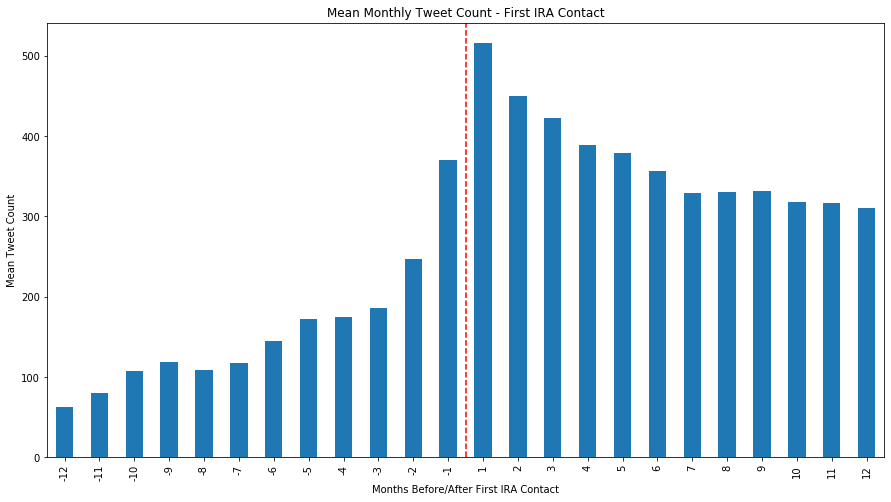

In [29]:
plt.figure()
# ax = english_count_average.mean().plot(color="white")
year1DF_count.mean().plot(kind='bar', figsize=(15,8),
                            title='Mean Monthly Tweet Count - First IRA Contact')
# ax.axhline(6, color="red", linestyle="--")
# ax.axvline(11.5, color="red", linestyle="--")
plt.axvline(11.5, color="red", linestyle="--")
plt.ylabel('Mean Tweet Count')
plt.xlabel('Months Before/After First IRA Contact')
# plt.savefig('BefAfmean1_withresponse.png')
# plt.savefig('BefAfmean1_noresponse.png')
plt.show()

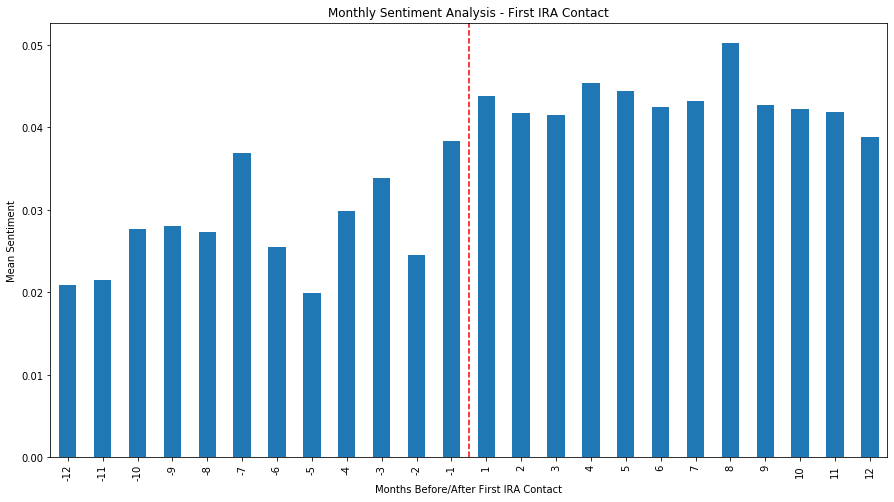

In [30]:
plt.figure()
# ax = english_count_average.mean().plot(color="white")
year1DF_sent.mean().plot(kind='bar', figsize=(15,8),
                            title='Monthly Sentiment Analysis - First IRA Contact')
# ax.axhline(6, color="red", linestyle="--")
# ax.axvline(11.5, color="red", linestyle="--")
plt.axvline(11.5, color="red", linestyle="--")
plt.ylabel('Mean Sentiment')
plt.xlabel('Months Before/After First IRA Contact')
# plt.savefig('BefAfsent1_withresponse.png')
# plt.savefig('BefAfsent1_noresponse.png')
plt.show()

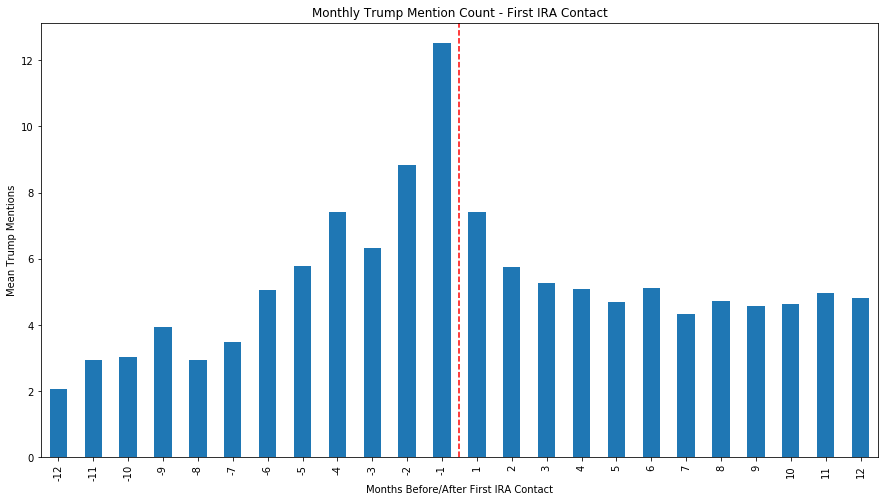

In [31]:
plt.figure()
# ax = english_count_average.mean().plot(color="white")
year1DF_trump.mean().plot(kind='bar', figsize=(15,8),
                            title='Monthly Trump Mention Count - First IRA Contact')
# ax.axhline(6, color="red", linestyle="--")
# ax.axvline(11.5, color="red", linestyle="--")
plt.axvline(11.5, color="red", linestyle="--")
plt.ylabel('Mean Trump Mentions')
plt.xlabel('Months Before/After First IRA Contact')
# plt.savefig('BefAftrump1_withresponse.png')
# plt.savefig('BefAftrump1_noresponse.png')
plt.show()

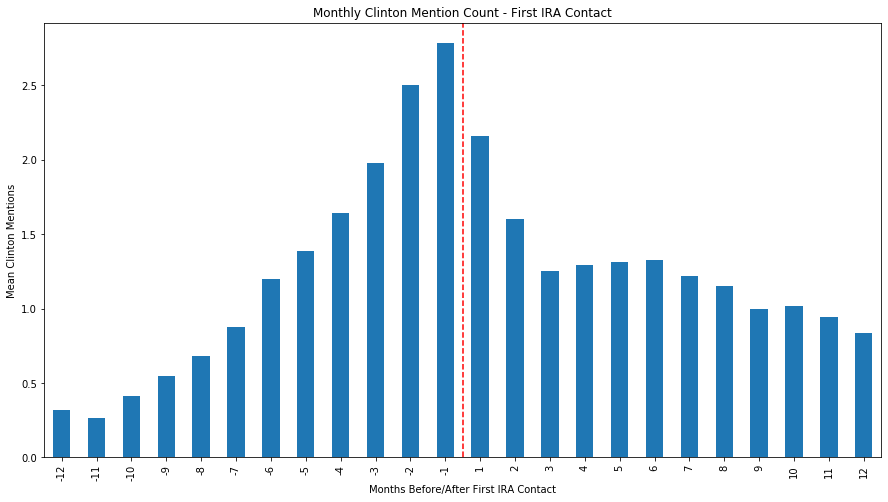

In [32]:
plt.figure()
# ax = english_count_average.mean().plot(color="white")
year1DF_clinton.mean().plot(kind='bar', figsize=(15,8),
                            title='Monthly Clinton Mention Count - First IRA Contact')
# ax.axhline(6, color="red", linestyle="--")
# ax.axvline(11.5, color="red", linestyle="--")
plt.axvline(11.5, color="red", linestyle="--")
plt.ylabel('Mean Clinton Mentions')
plt.xlabel('Months Before/After First IRA Contact')
# plt.savefig('BefAfclinton1_withresponse.png')
# plt.savefig('BefAfclinton1_noresponse.png')
plt.show()

**Contact Point Two Plots**

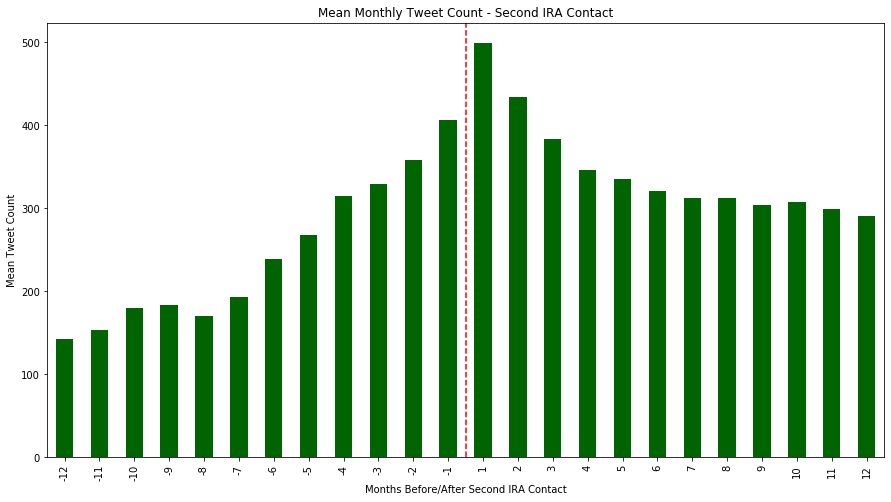

In [33]:
plt.figure()
# ax = english_count_average.mean().plot(color="white")
year2DF_count.mean().plot(kind='bar', figsize=(15,8), color = 'darkgreen',
                            title='Mean Monthly Tweet Count - Second IRA Contact')
# ax.axhline(6, color="red", linestyle="--")
# ax.axvline(11.5, color="red", linestyle="--")
plt.axvline(11.5, color="red", linestyle="--")
plt.ylabel('Mean Tweet Count')
plt.xlabel('Months Before/After Second IRA Contact')
# plt.savefig('BefAfmean2_withresponse.png')
# plt.savefig('BefAfmean2_noresponse.png')
plt.show()

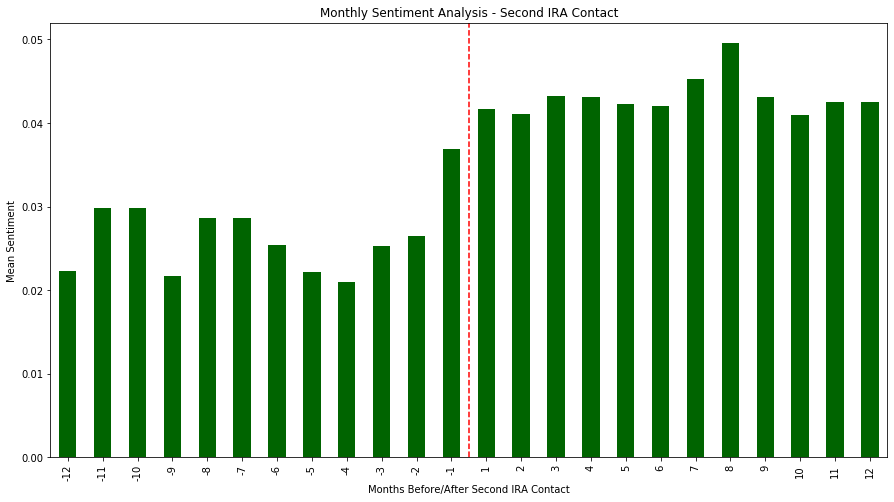

In [34]:
plt.figure()
# ax = english_count_average.mean().plot(color="white")
year2DF_sent.mean().plot(kind='bar', figsize=(15,8), color ='darkgreen',
                            title='Monthly Sentiment Analysis - Second IRA Contact')
# ax.axhline(6, color="red", linestyle="--")
# ax.axvline(11.5, color="red", linestyle="--")
plt.axvline(11.5, color="red", linestyle="--")
plt.ylabel('Mean Sentiment')
plt.xlabel('Months Before/After Second IRA Contact')
# plt.savefig('BefAfsent2_withresponse.png')
# plt.savefig('BefAfsent2_noresponse.png')
plt.show()

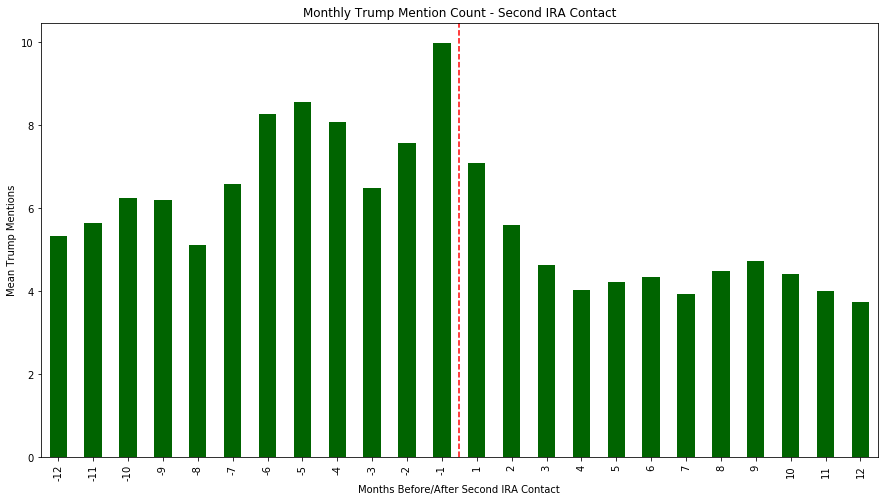

In [35]:
plt.figure()
# ax = english_count_average.mean().plot(color="white")
year2DF_trump.mean().plot(kind='bar', figsize=(15,8), color='darkgreen',
                            title='Monthly Trump Mention Count - Second IRA Contact')
# ax.axhline(6, color="red", linestyle="--")
# ax.axvline(11.5, color="red", linestyle="--")
plt.axvline(11.5, color="red", linestyle="--")
plt.ylabel('Mean Trump Mentions')
plt.xlabel('Months Before/After Second IRA Contact')
# plt.savefig('BefAftrump2_withresponse.png')
# plt.savefig('BefAftrump2_noresponse.png')

plt.show()

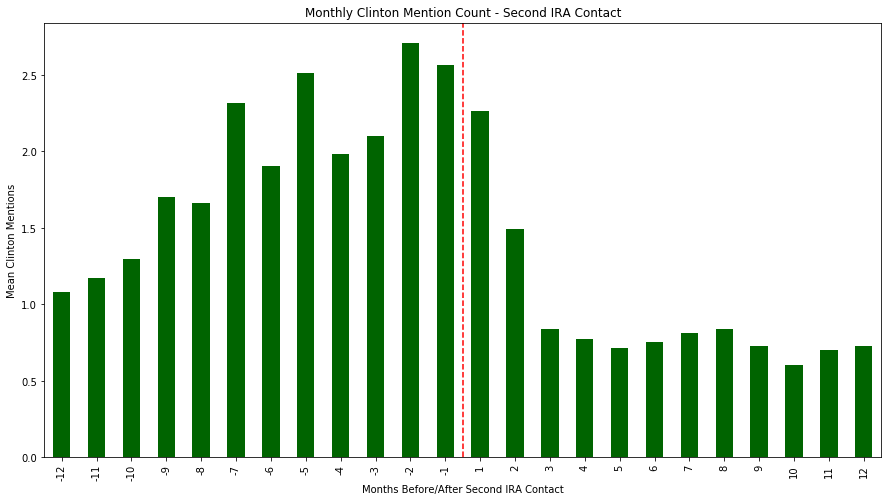

In [36]:
plt.figure()
# ax = english_count_average.mean().plot(color="white")
year2DF_clinton.mean().plot(kind='bar', figsize=(15,8), color='darkgreen',
                            title='Monthly Clinton Mention Count - Second IRA Contact')
# ax.axhline(6, color="red", linestyle="--")
# ax.axvline(11.5, color="red", linestyle="--")
plt.axvline(11.5, color="red", linestyle="--")
plt.ylabel('Mean Clinton Mentions')
plt.xlabel('Months Before/After Second IRA Contact')
# plt.savefig('BefAfclinton2_withresponse.png')
# plt.savefig('BefAfclinton2_noresponse.png')

plt.show()

**Contact Point Three Plots**

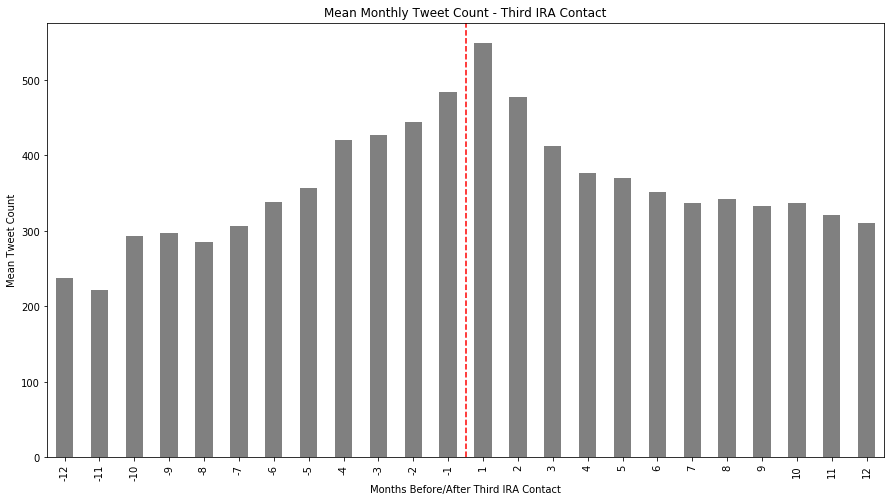

In [37]:
plt.figure()
# ax = english_count_average.mean().plot(color="white")
year3DF_count.mean().plot(kind='bar', figsize=(15,8), color = 'grey',
                            title='Mean Monthly Tweet Count - Third IRA Contact')
# ax.axhline(6, color="red", linestyle="--")
# ax.axvline(11.5, color="red", linestyle="--")
plt.axvline(11.5, color="red", linestyle="--")
plt.ylabel('Mean Tweet Count')
plt.xlabel('Months Before/After Third IRA Contact')
# plt.savefig('BefAfmean3_withresponse.png')
# plt.savefig('BefAfmean3_noresponse.png')

plt.show()

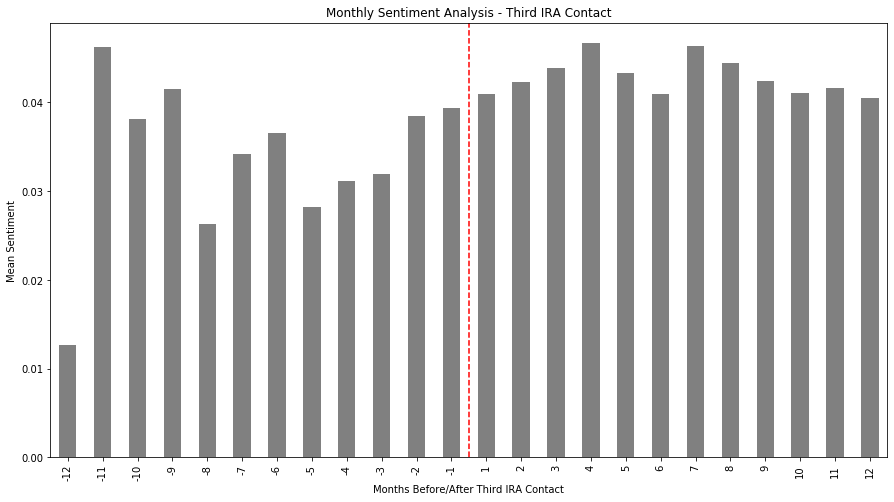

In [38]:
plt.figure()
# ax = english_count_average.mean().plot(color="white")
year3DF_sent.mean().plot(kind='bar', figsize=(15,8), color ='grey',
                            title='Monthly Sentiment Analysis - Third IRA Contact')
# ax.axhline(6, color="red", linestyle="--")
# ax.axvline(11.5, color="red", linestyle="--")
plt.axvline(11.5, color="red", linestyle="--")
plt.ylabel('Mean Sentiment')
plt.xlabel('Months Before/After Third IRA Contact')
# plt.savefig('BefAfsent3_noresponse.png')
# plt.savefig('BefAfsent3_withresponse.png')

plt.show()

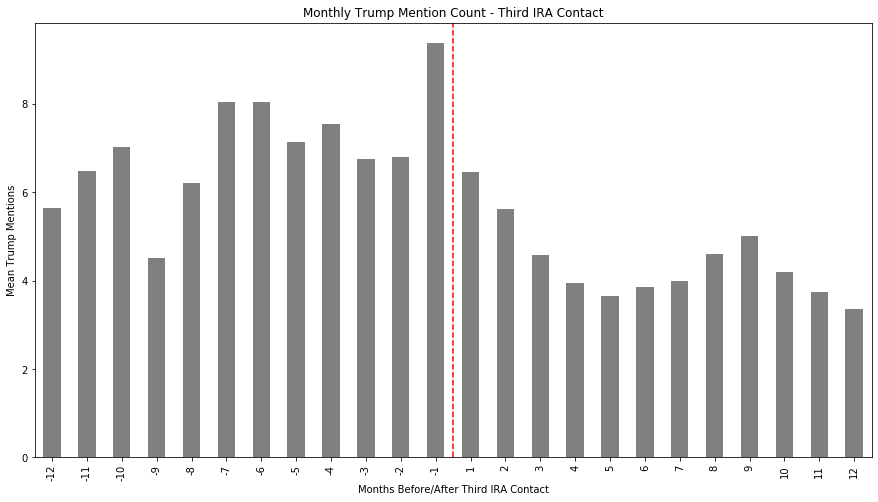

In [39]:
plt.figure()
# ax = english_count_average.mean().plot(color="white")
year3DF_trump.mean().plot(kind='bar', figsize=(15,8), color='grey',
                            title='Monthly Trump Mention Count - Third IRA Contact')
# ax.axhline(6, color="red", linestyle="--")
# ax.axvline(11.5, color="red", linestyle="--")
plt.axvline(11.5, color="red", linestyle="--")
plt.ylabel('Mean Trump Mentions')
plt.xlabel('Months Before/After Third IRA Contact')
# plt.savefig('BefAftrump3_withresponse.png')
# plt.savefig('BefAftrump3_noresponse.png')

plt.show()

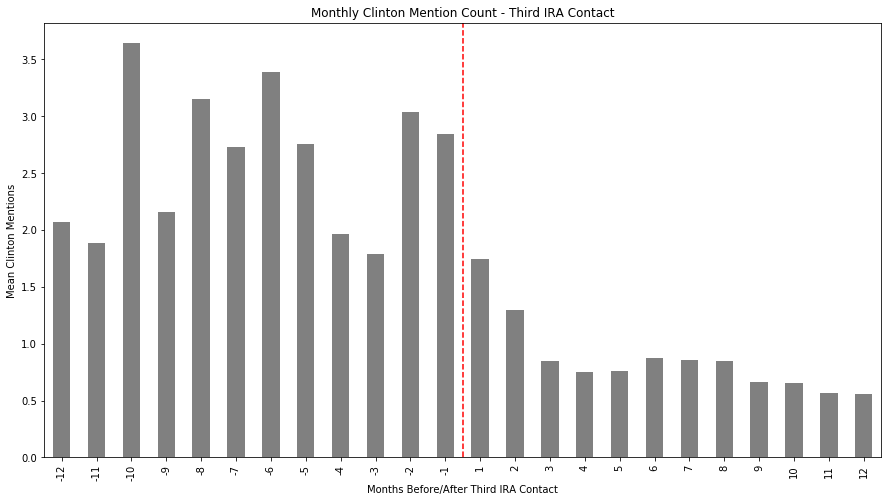

In [40]:
plt.figure()
# ax = english_count_average.mean().plot(color="white")
year3DF_clinton.mean().plot(kind='bar', figsize=(15,8), color='grey',
                            title='Monthly Clinton Mention Count - Third IRA Contact')
# ax.axhline(6, color="red", linestyle="--")
# ax.axvline(11.5, color="red", linestyle="--")
plt.axvline(11.5, color="red", linestyle="--")
plt.ylabel('Mean Clinton Mentions')
plt.xlabel('Months Before/After Third IRA Contact')
# plt.savefig('BefAfclinton3_withresponse.png')
# plt.savefig('BefAfclinton3_noresponse.png')

plt.show()

In [41]:
beforeAfterDF.head()

,username,first_contact,second_contact,third_contact,tweet_count,sentiment_scores,trump_count,clinton_count
0,tamarindlemur,2015-06-15,2016-02-05 00:00:00,2016-02-09 00:00:00,"[1484, 2274, 1759, 1178, 1191, 1354, 1187, 780...","[-0.0907167115902965, -0.09009718557607739, -0...","[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 8, 1, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1,maxzmorrison,2017-03-01,2017-03-01 00:00:00,None,"[0, 4, 2, 7, 6, 12, 3, 7, 7, 2, 24, 14, 23, 11...","[0, 0.6282, 0.0, 0.3241857142857143, 0.1196666...","[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,FarkMike,2015-10-29,2015-10-29 00:00:00,2015-10-29 00:00:00,"[0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 8, 5, 4, 0, ...","[0, 0, 0, 0, 0.67525, -0.22460000000000002, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,hashtagnpisces,2017-03-13,2017-03-13 00:00:00,2017-03-13 00:00:00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 54, 651, 1002, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0228574074074...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,LBaconBlood,2014-09-11,2014-09-11 00:00:00,2014-09-11 00:00:00,"[2, 2, 3, 8, 24, 15, 25, 37, 20, 12, 17, 36, 1...","[-0.42955, -0.0258, -0.3893333333333333, -0.05...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [42]:
count = 0
remove_users = []
for i in range(len(beforeAfterDF)):
# for i in range(10):
    first_contact = beforeAfterDF['first_contact'][i]
    first_tweety = dt.strptime(first_tweet_dict[beforeAfterDF['username'][i]], "%Y-%m-%d")
    if first_tweety >= first_contact:
        remove_users.append(beforeAfterDF['username'][i])
#         print(beforeAfterDF['username'][i])
#         print(first_tweety)
#         print(first_contact)
        count += 1
print(count)
    

175


In [43]:
removeDF = pd.DataFrame(remove_users)

In [44]:
removeDF.columns = ['username']

In [45]:
removeDF.head()

,username
0,rocketmanxl1
1,csbjaf
2,budgieofdespair
3,drivn2xl
4,CaptainNeil96


In [46]:
removeDF.to_csv('removeUsers_DidNotMentionBackUsers.csv')